# Programming Assignment 2: Triage

Now that you're familiar with Jupyter notebooks and have had some experience
working with text data, it's time to begin investigating some real NLP tasks.
In this assignment, you'll be focusing specifically on text classification,
and we'll investigate two commonly used models for
text classification tasks.

Text classification tasks come up in a huge range of contexts; quite often we
may be provided with text data in some form and be interested in labeling or
categorizing it in some way. In this assignment, we'll be looking at one such
application.

## Task: Message Classification for Disaster Aid

Victims of natural disasters have urgent needs for food, water, shelter,
medicine, and other forms of aid.  These needs are often communicated through
text messages, social media posts, and local newspapers. Because of their
ability to automatically process large amounts of text, NLP techniques can
play an important role in ensuring that people receive potentially life-saving
aid.

Our goal with this data will be to perform text classification on messages sent
in the aftermath of natural disasters. Specifically, you will need to determine
whether a specific message is about aid.

## Data Investigation

As usual, the first thing to do is to understand and characterize the data!

The data for this assignment contains about 26K documents from several major
 natural disasters:

* [Earthquake in Haiti (2010)](https://en.wikipedia.org/wiki/2010_Haiti_earthquake)
* [Floods in Pakistan (2010)](https://en.wikipedia.org/wiki/2010_Pakistan_floods)
* [Earthquake in Chile (2010)](https://en.wikipedia.org/wiki/2010_Chile_earthquake)
* [Hurricane Sandy in North America (2012)](https://en.wikipedia.org/wiki/Hurricane_Sandy)

These documents are either text messages, social media (Twitter) posts,
or snippets from news articles. In addition to the specific events listed above,
the dataset contains a number of news articles spanning dozens of different
disasters. All messages have been translated and annotated by humans on the
crowdsourcing platform CrowdFlower (now Figure-Eight). However, some of the
translations are not perfect, and you may encounter some words in other
languages. Unfortunately, NLP researchers often have to work with "messy"
data. If you're curious about the crowdsourcing translation effort for messages
from Haiti in particular, feel free to check out [this paper](https://nlp.stanford.edu/pubs/munro2010translation.pdf).

Your task is to classify each document as being aid-related (class "aid") or
not aid-related (class "not"). Messages that are aid-related include
individuals' requests for food/water/shelter/etc. The aid class also includes
news reports about dire situations and disaster relief efforts.

Below are several examples of aid-related documents (belonging to class "aid"):

* Hello Good Morning We live on 31 Delmas we are without water without food and
what we had have finished Please do something for us!
* I am sending this SMS from Layah district for my sister whose house has got
destroyed in a flood. So, the problem she faces now is that she hasn't got any
'Watan Card'or any financial aid from the government. She has 5 children too.
* Redcross came to my house and gave my family food ... Guess were not getting
power anytime soon . #sandy #RedCross
* Relief officials have stressed the vital importance of bringing in clean
drinking water and sanitation equipment to avoid deadly epidemics that in a
worst case scenario could claim as many or more lives than the tsunami itself.

Below are several examples of non-aid-related documents
(belonging to class "not"):

* A cold front is found over Cuba this morning. It could cross Haiti tomorrow.
Isolated rain showers are expected over our region tonight.
* Hurricane : A storm which New Yorkers use as an excuse to drink and eat junk
food in their pajamas for 48 hours . #sandy
* By secret ballot, the Council elected Pakistan, Bahrain and the Republic of
Korea from the Asian States, while Iran and Saudi Arabia did not receive enough
votes to qualify.

The data is divided into a training set, development (validation) set, and
test set. Recall that the training set is used to learn (compute the statistics
for) your model. These statistics are then used to classify the documents in the
development and test sets. For this assignment, you have access to the
training set and the dev set. The test set is hidden, but your submission
will be evaluated on it as well.


Let's take a look at some of the data. First, we'll import some packages and
helper methods that we require (you can see the implementation of the helper
methods in util.py).

__NOTE: You should NOT import or use any other packages except the ones imported
below and other packages in the Python standard library. This means you should
not use spaCy, NLTK, gensim, or other functionality in scikit-learn besides
CountVectorizer, even though those are provided in the conda
environment we set up for you. If your solution uses any such extra dependencies,
it will fail the autograder.__

In [12]:
import operator
import math
from typing import List, Dict, Union
import matplotlib.pyplot as plt
from collections import defaultdict

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from util import load_data, Classifier, Example, evaluate, remove_stop_words

We've defined a Dataset class for you to store the loaded data, and a function
load_data() to load it for you.

In [7]:
dataset = load_data("./data/triage")
print(type(dataset))

<class 'util.Dataset'>


Inside the loaded dataset, you can find the training and development sets,
each of which is a list of Examples:

In [8]:
print("dataset.train contains {} examples".format(len(dataset.train)))
print(type(dataset.train[0]))

dataset.train contains 21046 examples
<class 'util.Example'>


When loading the data, load_data will automatically load each line as a separate
example and give it the corresponding label. It will also take the line and
segment it into a list of words.

The label is an integer that can take only one of two values (1 for aid, 0 for
not aid).

In [9]:
print("First training example:")
print("Words: {}".format(dataset.train[0].words))
print("Label: {}".format(dataset.train[0].label))

First training example:
Words: ['we', 'are', 'suffering', 'because', 'of', 'our', 'new', 'passorts', 'were', 'not', 'done']
Label: 0


Finally, load_data() will also automatically shuffle your data for you, so the
examples will be in a random order.

It's not strictly necessary, but you may find it useful to know the following
additional information about the data:

- The training set is located in: ```data/train.csv```
- The dev set is located in: ```data/dev.csv```

Within each of these csv files, each line is a single example, consisting
of a document (string) and a corresponding label.

Note that the data you are given is already preprocessed;
all punctuation has been removed (except hashtags and apostrophes) and all text
has been converted to lowercase. Depending on the specific NLP task,
preprocessing can significantly improve performance. You do not need to do any
additional preprocessing for this task.


## First Approach: Naive Bayes

Now that we have our data set up, we can get started on implementing some
classifiers! The first approach we'll try is Naive Bayes, which we discussed
in the last few videos (if this doesn't ring a bell, definitely go back and
revisit the lectures/slides on Naive Bayes).

To help you, here's a skeleton implementation to get you started:

In [125]:
class NaiveBayesClassifier(Classifier):
    """
    TODO: Implement the Multinomial Naive Bayes classifier with add-1 smoothing
    (Laplace smoothing)
    """
    def __init__(self,
                 filter_stop_words=False,
                 use_bigrams=False):
        super().__init__(filter_stop_words, use_bigrams)

        # TODO: add other data structures needed in classify() or train()
        self.count_pos = defaultdict(int)
        self.count_neg = defaultdict(int)
        self.vocab = dict()
        self.num_doc_pos = 0
        self.num_doc_neg = 0
        self.num_pos = 0
        self.num_neg = 0
        
        
    def train(self, examples: List[Example]) -> None:
        """
        TODO: Implement a function that takes in a list of labeled
        examples and trains the classifier.
        """
        # construct vocab and counts
        if self.use_bigrams:
            for example in examples:
                words = remove_stop_words(example.words, self.stop_words) if self.filter_stop_words else example.words
                words_full = ['<s>'] + words + ['</s>']
                if example.label == 0: 
                    for i in range(1, len(words_full)):
                        bigram = (words_full[i - 1], words_full[i])
                        self.count_neg[bigram] += 1
                    self.num_doc_neg += 1
                else:
                    for i in range(1, len(words_full)):
                        bigram = (words_full[i - 1], words_full[i])
                        self.count_pos[bigram] += 1
                    self.num_doc_pos += 1
        else:
            for example in examples:
                words = remove_stop_words(example.words, self.stop_words) if self.filter_stop_words else example.words
                if example.label == 0: 
                    for w in words:
                        self.count_neg[w] += 1
                    self.num_doc_neg += 1
                else:
                    for w in words:
                        self.count_pos[w] += 1
                    self.num_doc_pos += 1
        self.vocab = set(list(self.count_pos.keys()) + list(self.count_neg.keys()))                      
        self.num_pos = sum(self.count_pos.values())
        self.num_neg = sum(self.count_neg.values())
            

    def classify(self, examples: List[Example],
                 return_scores: bool = False) -> Union[List[int], List[float]]:
        """
        TODO: Implement a function that takes a list of examples and predicts
        their labels using the learned classifier.

        If return_scores = True, return the score prob(label = 1 | example)
        for each example instead.
        """
        sol = []
        prob_pos = self.num_doc_pos / (self.num_doc_neg + self.num_doc_pos)
        prob_neg = self.num_doc_neg / (self.num_doc_neg + self.num_doc_pos)
        for example in examples:
            pos_logprob = math.log(prob_pos)
            neg_logprob = math.log(prob_neg)
            tprob_pos = prob_pos # calc p(wi)
            tprob_neg = prob_neg
            words = remove_stop_words(example.words, self.stop_words) if self.filter_stop_words else example.words
            if self.use_bigrams:
                words_full = ['<s>'] + words + ['</s>']
                for i in range(1, len(words_full)):
                    bigram = (words_full[i - 1], words_full[i])  
                    pos_logprob += math.log((self.count_pos[bigram] + 1) / (self.num_pos + len(self.vocab)))
                    neg_logprob += math.log((self.count_neg[bigram] + 1) / (self.num_neg + len(self.vocab)))
            else:
                for w in words:
                    pos_logprob += math.log((self.count_pos[w] + 1) / (self.num_pos + len(self.vocab)))
                    neg_logprob += math.log((self.count_neg[w] + 1) / (self.num_neg + len(self.vocab)))

            if return_scores:
                sol.append(math.exp(pos_logprob)/(math.exp(pos_logprob) + math.exp(neg_logprob) + 10**-8))
            else:
                if pos_logprob > neg_logprob:
                    sol.append(1)
                else:
                    sol.append(0)
        return sol
            

    def get_vocab_probabilities(self, label: int) -> Dict:
        """
        TODO: Implement a function to return a dictionary of n-gram ->
        p(label | n-gram)  for every n-gram in the vocabulary.

        The n-grams will be bigrams if use_bigram = True, otherwise they
        will be unigrams.
        """
        sol = dict()
        for v in self.vocab:
#             pv = ((self.count_pos[v] + 1) / (self.num_pos + len(self.vocab)) * prob_pos) + \
#                  ((self.count_neg[v] + 1) / (self.num_neg + len(self.vocab)) * prob_neg)
#             if label == 1:
#                 sol[v] = ((self.count_pos[v] + 1) / (self.num_pos + len(self.vocab)) * prob_pos) / pv
#             else:
#                 sol[v] = ((self.count_neg[v] + 1) / (self.num_neg + len(self.vocab)) * prob_neg) / pv
            p = self.classify([Example([v], None)], return_scores=True)
            if label == 1:
                sol[v] = p[0]
            else:
                sol[v] = 1 - p[0]
        return sol


Your job is to finish implementing the
NaiveBayesClassifier class!

The interface is very simple:

* train() takes in a list of training Examples and updates the classifier based
on the data (you'll want to save some information into the classifier class)
* classify() takes a list of Examples (they will have labels, but
you should not use them) and return a corresponding list of predicted labels
(1 or 0) in the same order. If return_scores = True, it will return the score
prob(label = 1 | example) for each example instead.
* get_vocab_probabilities(label) should return a dictionary of n-gram ->
p(label | n-gram)  for every n-gram in the vocabulary.

Beyond that, everything else is up to you! You're free to add other helper
methods or any other data structures/instance variables that you need.

__WARNING:__ Do NOT change the interface of train() or classify(), as these
will be called directly when grading.

With that said, we do have some hints and suggestions that might help along
the way. It's totally possible to get a working solution without following
all of these suggestions, so feel free to use or ignore them as you'd like:

* We strongly recommend computing the probabilities as log
probabilities in your implementation. Recall that your Naive Bayes prediction
will be the argmax of a product of many probabilities (the prior probability
$P(c)$ and a bunch of conditional probabilities $P(x | c)$ ). Each of these can
individually be small numbers, so if you multiply many of them
together, they may rapidly approach zero and even get rounded to 0, which will
make it difficult or impossible for you to compare the actual values accurately.
Instead, you can take the log of the probability, which will transform the
product into a sum of logs. These will avoid any such bad behavior. And because
log is a monotonically increasing function, if $log(x) > log(y)$ then $x > y$.
So when computing your argmax, you can just compare the log probabilities
directly and never need to worry about the true probabilities!
* For the purposes of implementing Laplace Smoothing (+1 smoothing), it may be
helpful to keep track of the vocabulary (the set of all words you've
seen in the training data) or at least its' size. The Python set() class
may be useful here.
* There are a few different ways you can go about storing the information from
learning in the NaiveBayesClassifier object. Ultimately, when classifying you'll
need to compute probabilities from the counts, but it's up to you whether you'd
like to store the raw counts or the computed probabilities.
* You may find Python's [defaultdict](https://docs.python.org/3/library/collections.html#collections.defaultdict) helpful
in your implementation when counting.
* Don't forget to implement your classifiers so they behave differently depending
on if stop word filtering is enabled or bigrams are used.
* You can filter stop words using the `remove_stop_words` function in `util.py`. If `filter_stop_words` is `True`, the `Classifier` will have a list of stop words stored in `self.stop_words`.
* When using bigrams, don't forget to add the start and end markers.
* Remember that in Python, assignment is by reference, not by value, for
non-primitive types. Or to put things more simply, when you're assigning an
existing list or dict to a new variable, it does NOT make a copy. It just gives
a reference to the existing list or dict.

```
a = [1, 2, 3]

# This does NOT make a copy of a. b now points to the same list as a
b = a

b.append(4)

# Prints "[1, 2, 3, 4]"
print(a)

# If you'd like to make a copy of a list, you should do it explicitly
b = a.copy()

b.append(5)

print(b) # Prints "[1, 2, 3, 4, 5]"
print(a) # Prints "[1, 2, 3, 4]"
```

* Our reference implementation is just under 100 lines of code (including the
skeleton code). It's quite possible that you can make a working implementation
in fewer lines (or more lines, that's totally fine too). But if your
implementation is way longer than this, that might be a sign that you are
over-complicating things.

Once your implementation is ready, you can try evaluating it from scratch using
this cell:

In [126]:
print("Performance on Unigrams, no stopword removal:")
nb_classifier = NaiveBayesClassifier(filter_stop_words=False, use_bigrams=False)
evaluate(nb_classifier, dataset)

print("Performance on Unigrams w/ stopword removal:")
nb_classifier_swr = NaiveBayesClassifier(filter_stop_words=True, use_bigrams=False)
evaluate(nb_classifier_swr, dataset)

print("Performance on Bigrams, no stopword removal:")
nb_classifier_bigrams = NaiveBayesClassifier(filter_stop_words=False, use_bigrams=True)
evaluate(nb_classifier_bigrams, dataset)

Performance on Unigrams, no stopword removal:
Accuracy (train): 0.82946878266654
Accuracy (dev): 0.731441896618733
Performance on Unigrams w/ stopword removal:
Accuracy (train): 0.8446735721752352
Accuracy (dev): 0.7302759424795958
Performance on Bigrams, no stopword removal:
Accuracy (train): 0.9601824574741044
Accuracy (dev): 0.7174504469490867


Our implementation (using unigrams and no stopword removal) scored around 0.829
on the training data and 0.732 on the dev data, so if you're in that ballpark
that probably means that your implementation is working well!

## Evaluation

Once we've implemented and trained our model, it's often helpful to do some
investigating to confirm that it's behaving the way we expect.

For a Naive Bayes model, there's a couple of different ways we can do this.
One good sanity check is to examine the learned conditional probabilities for
each of the words in the vocabulary. Specifically, we want to find the words
for which the probability of a particular label is high. For example, to
find the words that the model thinks best indicate an aid-related message,
we would want to find words with a high value of $P(\text{label} = 1 | \text{word})$.


We can do this easily by calling the
get_vocab_probabilities() method that we asked you to implement.

Let's print out the top 10 highest-probability words for each label
(positive and negative):

In [127]:
vocab_probs_positive = nb_classifier.get_vocab_probabilities(1)
top_10_positive = sorted(vocab_probs_positive.items(),
                         key=operator.itemgetter(1), reverse=True)[:10]

for word, prob in top_10_positive:
    print("{}: prob = {}".format(word, prob))


starving: prob = 0.967553058956026
quilts: prob = 0.9385501250749573
clercine: prob = 0.9290352748350298
pahore: prob = 0.9160340538602407
rushed: prob = 0.9043517841374287
dispatched: prob = 0.9011252359533486
turkey: prob = 0.8972004820227193
quarters: prob = 0.8972004820227193
hungry: prob = 0.8900272901675844
mobilised: prob = 0.8791257415286071


In [128]:
vocab_probs_negative = nb_classifier.get_vocab_probabilities(0)
top_10_negative = sorted(vocab_probs_negative.items(),
                         key=operator.itemgetter(1), reverse=True)[:10]

for word, prob in top_10_negative:
    print("{}: prob = {}".format(word, prob))

candidates: prob = 0.9692064539679244
scholarship: prob = 0.9663730226452778
darling: prob = 0.9663730226452778
reopening: prob = 0.9629653209275639
updates: prob = 0.9503991536185716
#santiago: prob = 0.9503991536185716
aur: prob = 0.9503991536185716
translated: prob = 0.9503991536185716
reopen: prob = 0.9503991536185716
translate: prob = 0.9503866354495558


Do these seem plausible to you? Do they match your expectations/agree with
your intuition?

Another good thing to check is where your model made errors. In this case, our
task was binary classification, so there are two possible types of errors
that could have occurred:

* Our model predicted a high probability of label = 1 for a negative example
(false positives)
* Our model predicted a low probability of label = 1 for a positive example
(false negatives)

We can look for exactly these two types of errors using the "return_scores"
flag we asked you to implement for the classify() method.

In [129]:
def get_false_negatives_and_false_positives(classifier, examples):
    predicted_scores = classifier.classify(examples, return_scores=True)

    false_negatives = []
    false_positives = []

    for pred_score, example in zip(
            predicted_scores, examples):
        if example.label == 1 and pred_score < 0.5:
            false_negatives.append((example.words, pred_score))
        elif example.label == 0 and pred_score >= 0.5:
            false_positives.append((example.words, pred_score))

    return false_negatives, false_positives

fn, fp = get_false_negatives_and_false_positives(nb_classifier, dataset.dev)

Now that we have the false negatives and false positives, we can find the
"worst" ones and examine them to try to figure out where our model went wrong.

The "worst" ones would be:
* The false negatives with the lowest probabilities of label = 1
* The false positives with the highest probabilities of label = 1

In [130]:
top_10_fn = sorted(fn,
                   key=operator.itemgetter(1))[:10]
for words, prob in top_10_fn:
    print("prob = {}: {}...".format(prob, words[:min(len(words), 10)]))

prob = 0.0: ['like', 'that', 'we', 'want', 'a', 'fair', 'representation', 'at', 'the', 'regional']...
prob = 0.0: ['emerging', 'viral', 'diseases', 'such', 'as', 'ebola', 'marburg', 'hemorrhagic', 'fever', 'and']...
prob = 0.0: ['we', 'are', 'cooped', 'up', 'all', 'day', 'here', 'tarpaulin', 'sheets', 'will']...
prob = 0.0: ['although', 'drought', 'in', 'djibouti', 'is', 'a', 'cyclical', 'phenomena', 'this', 'phase']...
prob = 0.0: ['for', 'example', 'in', 'australia', 'the', 'nswru', 'has', 'organised', 'a', 'charity']...
prob = 0.0: ['we', 'are', 'rescue', 'ministries', 'church', 'a', 'soup', 'kitchen', 'and', 'food']...
prob = 0.0: ['diets', 'for', 'households', 'with', 'poor', 'and', 'limited', 'consumption', 'lack', 'animal']...
prob = 0.0: ['we', 'are', 'afraid', 'of', 'a', 'huge', 'mudslide', 'triggered', 'by', 'heavy']...
prob = 0.0: ['one', 'year', 'ago', 'when', 'a', 'catastrophic', 'earthquake', 'hit', 'china', 'canadians']...
prob = 0.0: ['putih', 'river', 'and', 'pabelan',

In [131]:
if len(fp) == 0:
    print("No false positives found!")

top_10_fp = sorted(fp, key=operator.itemgetter(1), reverse=True)[:10]
for words, prob in top_10_fp:
    print("prob = {}: {}".format(prob, words))

No false positives found!


Do these mistakes seem reasonable/sensible? Why do you think the classifier
misclassified them?

Could some of these misclassifications be avoided if we had access to more
training data? Or do some of them stem from the limitations of the Naive Bayes
model itself (Hint: think about what assumptions go into the Naive Bayes model)?

Hopefully these questions have gotten you thinking about what your model
is doing and what its weaknesses and problems might be.

If you have time, we encourage you to spend some more time playing around with
your model before moving on.

Finally, when computing your model's performances with the different settings
(unigrams vs. bigrams, no stop word removal vs. stop word removal), you may have
noticed something surprising.

In general, we would expect models using bigrams to outperform models using
unigrams (why?). And probably the same for stop word removal in many cases.

However, you may have found that on this dataset, this does not necessarily
occur! This does not mean that your implementation is broken or incorrect
(although you should definitely double-check just to be sure).

Why do you think this might be happening? What could be changed to get the
expected behavior?

__HINT:__ It may be helpful to consider the differences between the training
set and dev accuracies.

__HINT:__ Think back to our discussion of overfitting in the group work.

## A Second Attempt: Logistic Regression

Now let's try tackling the same dataset with a different type of classifier:
logistic regression.


First, let's start off with some preliminaries to double-check our NumPy skills
and our understanding of the logistic regression algorithm.

One of the building blocks of logistic regression is the sigmoid function, which
we described in lecture. It's the method we use to convert the outputs of our
computation $(z = w * x + b)$ from a real number between negative infinity
and infinity to a probability between 0 and 1. Let's try implementing the sigmoid function.

In [132]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    """
    TODO: Implement the sigmoid function.

    Args:
        x: A numpy array.
    Returns:
        s: The numpy array with sigmoid applied element-wise

    HINT: use np.exp() because your input can be a numpy array
    """
    return 1 / (1 + np.exp(-x))

Once you're satisfied with your implementation, let's try visualizing it to
double-check that we have the right idea.

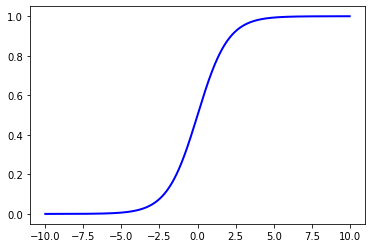

In [133]:
x = np.arange(-10, 10, .01)
y = sigmoid(x)
plt.plot(x,y, color='blue', lw=2)
plt.show()

Hopefully it looks reasonable! Now there's just one more building block we need,
the logistic loss function (otherwise known as cross-entropy loss). 

Intuitively, it is simply a way to measure how far our prediction
$y_{\text{pred}} = \sigma(WX + b)$ is from the true label $y_{\text{true}}$.

Using the formulation covered in lecture and in the notes, implement the
logistic loss function:

__NOTE:__ Your function should take in not just a single predicted label
and true label, but a vector of predictions and a vector of true labels. This
shouldn't affect your implementation much, as numpy allows you to operate
naturally on vectors.

__NOTE:__ Your function should return the average logistic loss over all the
examples as a single float.

In [143]:
def logistic_loss(y_pred: np.ndarray, y_true: np.ndarray) -> float:
    """
    TODO: Implement the computation of the logistic loss function.

    Args:
        y_pred: A 1D vector of predicted labels for each example, of shape
        (num_examples,).
        y_true: A 1D vector of true labels for each example, of shape
        (num_examples,).

    Returns:
        The average logistic loss over all examples as a float.
    """
    return -np.mean(y_true * np.log(y_pred + 10**-8) + (1 - y_true) * np.log(1 - y_pred + 10**-8))

To check our implementation, let's compare it to our intuition about how the
loss should behave. It's supposed to represent how far our prediction is from
the true label. In other words, if our prediction is way off, the loss should be
very high. But as our prediction gets closer to the true value, it should drop
 towards 0.

Let's consider the following cases:

In [144]:
def print_loss(y_pred, y_true):
    print("Predicted = {}, True = {} : Loss = {}".format(
          y_pred, y_true, logistic_loss(np.array([y_pred]),
                                        np.array([y_true]))))

print_loss(0, 1)
print_loss(0.1, 1)
print_loss(0.3, 1)
print_loss(0.5, 1)
print_loss(0.7, 1)
print_loss(0.9, 1)
print_loss(0.99, 1)
print_loss(0.999999, 1)
print_loss(1, 1)


Predicted = 0, True = 1 : Loss = 18.420680743952367
Predicted = 0.1, True = 1 : Loss = 2.3025849929940505
Predicted = 0.3, True = 1 : Loss = 1.2039727709926034
Predicted = 0.5, True = 1 : Loss = 0.6931471605599454
Predicted = 0.7, True = 1 : Loss = 0.35667492965301817
Predicted = 0.9, True = 1 : Loss = 0.10536050454671517
Predicted = 0.99, True = 1 : Loss = 0.01005032575249135
Predicted = 0.999999, True = 1 : Loss = 9.900004900288314e-07
Predicted = 1, True = 1 : Loss = -9.999999889225291e-09


Do the results seem reasonable? Do they agree with your intuition?

What happens when y_pred = y_true? What happens when y_pred = 0 and y_true = 1?

Do these seem reasonable? Do they agree with what you expect from the formula
for the logistic loss?

Why might this behavior be OK in practice, given how we are going to use the
logistic loss (i.e. in gradient descent)?

Now, using the two parts you implemented above, we finally have everything we
need to implement gradient descent, the algorithm that we'll use to learn our
logistic regression parameters from data.

We'll talk more about it next week in the context of neural networks, but for
now we've implemented it for you, so you don't need to do anything here.

However, if you're interested we encourage you to take a look and try to
understand what the function is doing, as well as what each of the
parameters (alpha, epsilon, num_iterations) does.

You can also see how it makes use of the sigmoid and logistic loss functions
we just implemented!

In [138]:
def gradient_descent(X: np.ndarray,
                     Y: np.ndarray,
                     batch_size: int = 2000,
                     alpha: float = 0.5,
                     num_iterations: int = 1000,
                     print_every: int = 100,
                     epsilon: float = 1e-8) -> (np.ndarray, float):
    """
    Runs batch gradient descent on the provided data and returns the resulting
    trained weight vector and bias.

    Args:
        X: A numpy array of shape (num_examples, num_features) containing
           the training data.
        Y: A numpy array of shape (num_examples,) containing the training
            labels.
        batch_size: The number of examples in each batch.
        alpha: The learning rate for gradient descent.
        num_iterations: The number of iterations to run gradient descent
                        for.
        print_every: How often (after how many iterations) to print the
                    loss and iteration number.
        epsilon: The early stopping condition. When the absolute change
                 in the loss is less than epsilon, gradient descent will
                 stop early.

    Returns:
        (np.ndarray, float): The learned weight vector W and bias b
    """
    W = np.zeros((X.shape[1],))
    b = 0

    Y = np.array(Y)
    loss = 0
    for i in range(num_iterations):
        if batch_size >= X.shape[0]:
            X_batch = X
            Y_batch = Y
        else:
            batch_indices = np.random.randint(X.shape[0], size=batch_size)
            X_batch = X[batch_indices, :]
            Y_batch = Y[batch_indices]

        A = sigmoid(np.dot(X_batch, W) + b)
        dW = np.mean(np.expand_dims(A - Y_batch, axis=1) * X_batch, axis=0)
        db = np.mean(A - Y_batch)
        W -= alpha * dW
        b -= alpha * db
        prev_loss = loss
        loss = logistic_loss(A, Y_batch)

        if abs(prev_loss - loss) < epsilon:
            break

        if (i+1) % print_every == 0:
            predictions = A
            predictions[predictions >= 0.5] = 1
            predictions[predictions < 0.5] = 0
            accuracy = np.mean(predictions == Y_batch)
            print("Iteration {}/{}: Batch Accuracy: {},  Batch Loss = {}".format(
                i + 1,
                num_iterations,
                accuracy,
                loss
            ))

    return W, b


Awesome, that wraps up the preliminaries! Without any further ado,
here's the skeleton code for the full logistic regression classifier. All you
have to do is finish it up.

It should be relatively straight-forward, given the functions you already
implemented above. If you need a helping hand, we've provided some hints and
suggestions below as well.

In [158]:
class LogisticRegressionClassifier(Classifier):
    """
    TODO: Implement the Logistic Regression classifier.
    """
    def __init__(self,
                 filter_stop_words: bool = None,
                 use_bigrams: bool = False,
                 batch_size: int = 2000,
                 alpha: float = 0.5,
                 num_iterations: int = 1000,
                 print_every: int = 100,
                 epsilon: float = 1e-8):
        super().__init__(filter_stop_words, use_bigrams)

        ngram = 2 if use_bigrams else 1
        tokenizer = str.split if self.filter_stop_words else None

        """
        self.vectorizer is a countVectorizer we have created for you. Use
        it to obtain a feature vector of word counts for each example
        in your training data.
        Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
        """
        self.vectorizer = CountVectorizer(min_df=20,
                                          ngram_range=(ngram, ngram),
                                          stop_words=self.stop_words,
                                          tokenizer=tokenizer)

        # Parameters to use for gradient_descent()
        self.batch_size = batch_size
        self.alpha = alpha
        self.num_iterations = num_iterations
        self.print_every = print_every
        self.epsilon = epsilon

        # TODO: add other data structures needed in classify() or train()
        self.num_features = 1
        self.weights = np.zeros(1)
        self.intercept = 0

    def train(self, examples: List[Example]) -> None:
        """
        TODO: Implement this!

        Implement a function to train a logistic regression model.

        HINT: Call gradient_descent() from above to return the learned weight
        vector and bias. You can save these for later use in classify().

        HINT: You should use the parameters (batch_size, alpha, num_iterations,
        print_every, epsilon) provided as arguments to the
        LogisticRegressionClassifier when calling gradient_descent().

        HINT: Call self.X.toarray() after you've populated self.X with counts.
        This converts it from a sparse matrix to a dense matrix so
        we can use it to perform gradient descent.
        """
        # create X
        corpus = []
        labels = []
        for example in examples:
            corpus.append(' '.join(example.words))
            labels.append(example.label)
        X_sparse = self.vectorizer.fit_transform(corpus)
        self.X = X_sparse.toarray()
        self.num_features = self.X.shape[1]
        self.weights, self.intercept = gradient_descent(
            X=self.X,
            Y=np.array(labels),
            batch_size=self.batch_size,
            alpha=self.alpha,
            num_iterations=self.num_iterations,
            print_every=self.print_every,
            epsilon=self.epsilon
        )
        

    def classify(self, examples: List[Example],
                 return_scores: bool = False) -> Union[List[int], List[float]]:
        """
        TODO: Implement this!

        HINT: If sigmoid(X * W + b) is greater or equal to 0.5, the example
        belongs to class 1 (positive class). Otherwise, it belongs to class 0
        (negative class). You can use the sigmoid function you implemented
        above.

        HINT: You should use the weight vector and bias you computed
        earlier in train().

        HINT: You can use np.dot or np.matmul to do matrix multiplication.
        """
        corpus_pred = []
        for example in examples:
            corpus_pred.append(' '.join(example.words))
        X_pred_sparse = self.vectorizer.transform(corpus_pred)
        X_pred = X_pred_sparse.toarray()
        A = sigmoid(np.dot(X_pred, self.weights) + self.intercept)
        sol = np.zeros(A.shape[0])
        sol[A >= 0.5] = 1
        return sol if not return_scores else A

    def get_weights(self) -> np.ndarray:
        """
        TODO: Implement a function to return the trained weights as a
        NumPy array of shape (num_features,)
        """
        return self.weights

Here are some tips/suggestions that may be useful to you:

* If you run into "RuntimeWarning: divide by zero encountered in log" issues,
try adding a very small number epsilon (like 1e-8) to the input any time
you call np.log(). This will ensure that the input to the log is never exactly
0, which gives an undefined result. __HINT:__ Check your logistic_loss function.
* Depending on your implementation, your model may take some time to train!

Once you're reasonably satisfied with your implementation, we can try
evaluating it in the exact same way as you did with your Naive Bayes classifier.

In [159]:
print("Performance on Unigrams, no stopword removal:")
lr_classifier = LogisticRegressionClassifier(filter_stop_words=False, use_bigrams=False)
evaluate(lr_classifier, dataset)

print("Performance on Unigrams w/ stopword removal:")
lr_classifier_swr = LogisticRegressionClassifier(filter_stop_words=True, use_bigrams=False)
evaluate(lr_classifier_swr, dataset)

# Note that we run for more iterations here
print("Performance on Bigrams, no stopword removal:")
lr_classifier_bigrams = LogisticRegressionClassifier(filter_stop_words=False, use_bigrams=True,
                                                     num_iterations=3000)
evaluate(lr_classifier_bigrams, dataset)

Performance on Unigrams, no stopword removal:
Iteration 100/1000: Batch Accuracy: 0.743,  Batch Loss = 0.540804698800816
Iteration 200/1000: Batch Accuracy: 0.7615,  Batch Loss = 0.5165495075946467
Iteration 300/1000: Batch Accuracy: 0.746,  Batch Loss = 0.5234428904683852
Iteration 400/1000: Batch Accuracy: 0.7495,  Batch Loss = 0.5065058229257048
Iteration 500/1000: Batch Accuracy: 0.7675,  Batch Loss = 0.49491359125650364
Iteration 600/1000: Batch Accuracy: 0.7745,  Batch Loss = 0.4764458099010278
Iteration 700/1000: Batch Accuracy: 0.7945,  Batch Loss = 0.46813283363421626
Iteration 800/1000: Batch Accuracy: 0.783,  Batch Loss = 0.47293894440477935
Iteration 900/1000: Batch Accuracy: 0.795,  Batch Loss = 0.4560227934934386
Iteration 1000/1000: Batch Accuracy: 0.7955,  Batch Loss = 0.43949649741067615
Accuracy (train): 0.7915043238620165
Accuracy (dev): 0.7730275942479595
Performance on Unigrams w/ stopword removal:
Iteration 100/1000: Batch Accuracy: 0.721,  Batch Loss = 0.56636123

Our implementation (using unigrams with no stop word removal) scored around
0.791 on the training data and 0.770 on the dev data, so if you're in that
ballpark that probably means that your implementation is working well!

## Evaluation

Again, now that we have our trained model, we can try to examine it to better
understand what it is doing.

If we think back to our Naive Bayes model, after training we have access to
the conditional probabilities for each word (n-gram) given each label. We
were able to examine them to get an idea of what words our model associates
with each label.

For our logistic regression model, after training we have access to a weight
vector that contains a weight for each feature. We can connect these weights
back to the list of features (in our case, these will be unigrams or bigrams,
depending on which one we used for our model).

Features with larger weights are those that the model associates with the
positive label, and those with smaller weights are those the model associates
with the negative label.

If it's not clear why this is true, try thinking back to the equation used
to compute the logistic regression output. If a weight for a feature is a large
positive number, and that feature appears in an example, what will happen
 to the output for that example? What about a feature with a large negative
 weight?

Let's examine the features with the largest and smallest weights in our
trained classifier:

In [160]:
features = lr_classifier.vectorizer.get_feature_names()
weights = lr_classifier.get_weights()

features_to_weights = [(features[i], weights[i])
                    for i in range(len(features))]

In [161]:
top_10_features = sorted(features_to_weights,
                   key=operator.itemgetter(1), reverse=True)[:10]
for feature, weight in top_10_features:
    print("{}: weight = {}".format(feature, weight))

food: weight = 1.2030304298717
tents: weight = 1.0253745682754163
aid: weight = 0.988514271036626
tent: weight = 0.9693890931301045
shelter: weight = 0.9690830634522438
victims: weight = 0.96345380399703
help: weight = 0.8585387846302754
relief: weight = 0.853630976886604
dead: weight = 0.7972143135185829
earthquake: weight = 0.7955129456746354


In [162]:
bottom_10_features = sorted(features_to_weights,
                            key=operator.itemgetter(1))[:10]
for feature, weight in bottom_10_features:
    print("{}: weight = {}".format(feature, weight))

job: weight = -0.9253641888905701
santiago: weight = -0.6118295835275541
notes: weight = -0.46869533865750934
message: weight = -0.4036374628531826
development: weight = -0.40113879476402825
level: weight = -0.3886522167938111
4636: weight = -0.35928990257170823
agriculture: weight = -0.3572360442374463
information: weight = -0.3473570558717477
go: weight = -0.3442153652035004


Do these features make sense to you? Do they agree with your intuition? Are
they similar to or different from the features/words you saw associated with
each class by the Naive Bayes model?

We can also do the same thing that we did with the Naive Bayes model by
identifying the "worst" errors our model makes on the dev set:

In [163]:
fn, fp = get_false_negatives_and_false_positives(lr_classifier, dataset.dev)

In [164]:
top_10_fn = sorted(fn,
                   key=operator.itemgetter(1))[:10]
for words, prob in top_10_fn:
    print("prob = {}: {}...".format(prob, words[:min(len(words), 10)]))

prob = 0.05501216148169356: ["i'd", 'like', 'to', 'get', 'more', 'information', 'about', 'the', 'possibility', 'of']...
prob = 0.0784671322901775: ['however', 'during', 'the', 'third', 'week', 'of', 'october', 'perhaps', 'in', 'reaction']...
prob = 0.08843385920153178: ['hi', '4636', 'did', 'you', 'give', 'the', 'news', 'for', 'tonight', 'on']...
prob = 0.08895419756146619: ['raising', 'the', 'alert', 'status', 'to', 'level', '4', 'the', 'highest', 'level']...
prob = 0.09492356393992551: ['downtown', 'santiago', 'security', 'scares', 'spreading', 'but', 'is', 'it', 'all', 'in']...
prob = 0.10745432627143679: ['ctfu', 'ahurricanesandy', 'dis', 'bitch', 'waz', 'walking', 'her', 'dog', 'and', 'i']...
prob = 0.10851636713725352: ['i', 'would', 'like', 'information', 'on', 'evacuation', 'of', 'haitians', 'who', 'would']...
prob = 0.11894790995270642: ['livestock', 'crops', 'rural', 'and', 'urban', 'housing', 'roads', 'river', 'and', 'canal']...
prob = 0.11962753090032366: ['in', 'terms', 'o

In [165]:
if len(fp) == 0:
    print("No false positives found!")

top_10_fp = sorted(fp, key=operator.itemgetter(1), reverse=True)[:10]
for words, prob in top_10_fp:
    print("prob = {}: {}...".format(prob, words[:min(len(words), 10)]))

prob = 0.997475797592249: ['these', 'communities', 'are', 'in', 'areas', 'experiencing', 'chronic', 'food', 'insecurity', 'environmental']...
prob = 0.9822722821245521: ['if', 'households', 'had', 'no', 'recourse', 'to', 'subsidized', 'maize', 'and', 'had']...
prob = 0.9796148310662881: ['i', 'am', 'a', 'licensed', 'teacher', 'i', 'am', 'licensed', 'in', 'cpr']...
prob = 0.9695976056499526: ['we', 'need', 'help', 'at', 'place', 'mausolee', 'facing', 'the', 'palais', 'de']...
prob = 0.9693893173482154: ['the', 'company', 'i', 'work', 'for', 'regeneron', 'pharmaceuticals', 'has', 'a', 'team']...
prob = 0.9540890190414776: ['mostly', 'young', 'people', 'they', 'spend', 'their', 'days', 'collecting', 'trash', 'spraying']...
prob = 0.9450007128177426: ['how', 'we', 'can', 'find', 'food', 'and', 'water', 'we', 'have', 'people']...
prob = 0.9395621152497591: ['even', 'as', 'oxfam', 'america', 'and', 'many', 'other', 'relief', 'and', 'development']...
prob = 0.9392761595248826: ['my', 'house',

Do these errors seem reasonable? Can you think of why the model may have made
them? Are they similar to or different from the errors you saw from the Naive
Bayes model?

Further questions to consider:

* Did logistic regression outperform Naive Bayes? Did you expect it to? Why or
why not?
* How do the different settings (unigrams vs. bigrams, stop word removal vs.
no stop word removal) affect the performance relative to each other? Relative
to Naive Bayes? Do these results seem reasonable/expected? If not, what might
explain what you're seeing?

## Evaluation Redux

__NOTE: Your implementation will not be evaluated on its performance
on this part!__

Now that we've verified that our methods behave correctly on a given
dataset, it is easy to apply them and evaluate on an alternative dataset and
see if they perform differently.

In `data/coronavirus`, we have provided a second dataset consisting of reddit
comments on posts related to the COVID-19 pandemic early last year. Each
example is a single line in the csv, consisting of a comment and associated
sentiment label (0 for negative, 1 for positive). It consists of around 4 times
 as many examples as the triage/disaster dataset.

The task on this dataset is to, given the text of a comment, predict its
sentiment label. This is an example of sentiment analysis (specifically
sentiment classification), another type of NLP task.

In this particular case, you could imagine using sentiment analysis tools
to get an approximate idea of the mood social media (i.e. Reddit) users feel
about the pandemic at a particular point in time. If we succeeded in training
a good classifier to identify positive and negative sentiment comments/posts,
we could use it to count the number of positive and negative posts each day,
giving an approximate measure of social media sentiment.

This information could be very useful for governments or NGOs trying to gauge
the public response to COVID-19 policies, or identify how the pandemic is
affecting mental health.

Although the task is different, we can straightforwardly load and examine
the new data the same way we did with the previous dataset:

In [139]:
covid_dataset = load_data("./data/coronavirus")
print(type(covid_dataset))

print("dataset.train contains {} examples".format(len(covid_dataset.train)))

print("First training example:")
print("Words: {}".format(covid_dataset.train[0].words))
print("Label: {}".format(covid_dataset.train[0].label))

<class 'util.Dataset'>
dataset.train contains 80000 examples
First training example:
Words: ['The', 'guy', 'left', 'it', 'for', 'only', '5', 'people', 'and', 'theyre', 'splitting', 'it', 'for', '13thats', 'even', 'nicer']
Label: 1


And we can also train our models in the same way:

In [140]:
nb_classifier = NaiveBayesClassifier(filter_stop_words=False, use_bigrams=False)

evaluate(nb_classifier, covid_dataset)

Accuracy (train): 0.8691
Accuracy (dev): 0.7835


In [166]:
lr_classifier = LogisticRegressionClassifier(filter_stop_words=False,
                                             use_bigrams=False)

evaluate(lr_classifier, covid_dataset, limit_training_set=True)

Iteration 100/1000: Batch Accuracy: 0.709,  Batch Loss = 0.6229198808168109
Iteration 200/1000: Batch Accuracy: 0.7645,  Batch Loss = 0.5383476878286864
Iteration 300/1000: Batch Accuracy: 0.797,  Batch Loss = 0.5211586268422418
Iteration 400/1000: Batch Accuracy: 0.8075,  Batch Loss = 0.48274134695625104
Iteration 500/1000: Batch Accuracy: 0.7975,  Batch Loss = 0.49138833432267465
Iteration 600/1000: Batch Accuracy: 0.812,  Batch Loss = 0.4671035672541479
Iteration 700/1000: Batch Accuracy: 0.8265,  Batch Loss = 0.4554413181849155
Iteration 800/1000: Batch Accuracy: 0.8195,  Batch Loss = 0.4566668017181523
Iteration 900/1000: Batch Accuracy: 0.8065,  Batch Loss = 0.4672099193802185
Iteration 1000/1000: Batch Accuracy: 0.8435,  Batch Loss = 0.4400768201662378
Accuracy (train): 0.82945
Accuracy (dev): 0.7914


What do you notice about the results you got on this dataset compared to the
previous one?

What about the relative performances of the two models? Has that changed? If so,
why do you think that might be?

Finally, for the logistic regression model, you can try adjusting the values
of some of the arguments to LogisticRegressionClassifier, like alpha or
num_iterations, re-running the evaluation, and seeing if the performance has
changed. We haven't really discussed what these values represent, but you
should be able to notice that by adjusting them you can significantly change
your model's performance!

These are examples of __hyperparameters__ of our model. You can
 think of them as adjustable settings that control how our model works and
 how it learns. Oftentimes you will want to experiment with different choices
 for these parameters to find ones that work best and give the best possible
 performance. This optimal choice of the hyperparameters
will depend on the particular dataset/task as well.

Once you're ready to submit, you can run the cell below to prepare and zip
up your solution:

In [ ]:
%%bash

if [[ ! -f "./pa2.ipynb" ]]
then
    echo "WARNING: Did not find notebook in Jupyter working directory. This probably means you're running on Google Colab. You'll need to go to File->Download .ipynb to download your notebok and other files, then zip them locally. See the README for more information."
else
    echo "Found notebook file, creating submission zip..."
    zip -r submission.zip pa2.ipynb deps/
fi


If you're running on Google Colab, see the README for instructions on
how to submit.

__Best of luck!__

__Some reminders for submission:__
* If you have any extra files required for your implementation to work, make
 sure they are in a `deps/` folder on the same level as `pa2.ipynb` and
 include that folder in your submission zip file.
 * Make sure you didn't accidentally change the name of your notebook file,
 (it should be `pa2.ipynb`) as that is required for the autograder to work.
* Go to Gradescope (gradescope.com), find the PA2 Triage assignment and
upload your zip file (`submission.zip`) as your solution.
* Wait for the autograder to run (it should only take a minute or so) and check
that your submission was graded successfully! If the autograder fails, or you
get an unexpected score it may be a sign that your zip file was incorrect.

